In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms
import seaborn as sns
import sklearn.model_selection as model_selection
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from sklearn import  linear_model
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import xgboost as xgb
%matplotlib inline

In [2]:
porto=pd.read_csv("/content/drive/My Drive/porto-seguro/train.csv");

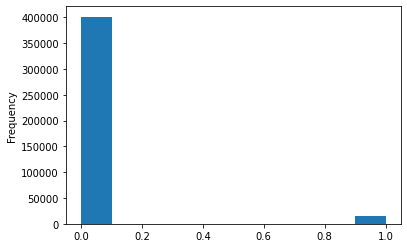

In [3]:
porto.target.plot.hist()

In [4]:
portowtnan=porto.replace(-1,np.nan)

In [5]:
portowtnan['missingmark']=portowtnan.isnull().sum(1)

In [6]:
portowtnan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416648 entries, 0 to 416647
Data columns (total 60 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              416648 non-null  int64  
 1   target          416648 non-null  int64  
 2   ps_ind_01       416648 non-null  int64  
 3   ps_ind_02_cat   416500 non-null  float64
 4   ps_ind_03       416648 non-null  int64  
 5   ps_ind_04_cat   416593 non-null  float64
 6   ps_ind_05_cat   412601 non-null  float64
 7   ps_ind_06_bin   416648 non-null  int64  
 8   ps_ind_07_bin   416648 non-null  int64  
 9   ps_ind_08_bin   416648 non-null  int64  
 10  ps_ind_09_bin   416648 non-null  int64  
 11  ps_ind_10_bin   416648 non-null  int64  
 12  ps_ind_11_bin   416648 non-null  int64  
 13  ps_ind_12_bin   416648 non-null  int64  
 14  ps_ind_13_bin   416648 non-null  int64  
 15  ps_ind_14       416648 non-null  int64  
 16  ps_ind_15       416648 non-null  int64  
 17  ps_ind_16_

In [7]:
portowtnan.drop(columns=['ps_car_03_cat','id'],axis=1,inplace=True)
target=portowtnan['target']
portowtnan.drop(columns=['target'],axis=1,inplace=True)
cols=portowtnan.columns

In [8]:
features_train, features_test, target_train, target_test = train_test_split(
portowtnan,target, test_size=0.10, random_state=1)


In [9]:
portowtnan=features_train

In [10]:
imp=SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp.fit(portowtnan)
portoclean=pd.DataFrame(imp.transform(portowtnan),columns=cols)
features_test=pd.DataFrame(imp.transform(features_test),columns=cols)
portoclean.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,missingmark
0,1.0,3.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.9,0.8,0.611351,11.0,0.0,8.0,1.0,13.0,1.0,1.0,0.0,1.0,20.0,3.0,0.447214,0.858646,0.429535,2.645751,0.9,0.8,0.2,3.0,1.0,8.0,4.0,8.0,2.0,7.0,5.0,1.0,3.0,8.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
1,3.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,1.0,0.0,0.7,0.6,0.985203,9.0,1.0,0.0,0.0,10.0,1.0,1.0,1.0,1.0,28.0,3.0,0.374166,0.839114,0.324808,3.000000,0.5,0.3,0.7,3.0,3.0,7.0,3.0,10.0,2.0,10.0,4.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,5.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,1.0,0.0,0.7,0.0,0.633936,10.0,1.0,0.0,1.0,11.0,1.0,1.0,0.0,1.0,99.0,2.0,0.315595,0.558240,0.368782,2.000000,0.1,0.5,0.9,2.0,0.0,6.0,2.0,10.0,1.0,8.0,7.0,0.0,1.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
3,0.0,1.0,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,1.0,0.0,0.0,0.9,0.2,0.590551,6.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,70.0,3.0,0.374166,0.778455,0.393700,3.162278,0.6,0.4,0.2,1.0,1.0,8.0,1.0,8.0,1.0,8.0,3.0,0.0,4.0,13.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,1.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.4,0.0,0.881760,11.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0,10.0,2.0,0.316228,0.609955,0.376829,2.645751,0.0,0.2,0.1,1.0,3.0,4.0,2.0,6.0,4.0,9.0,5.0,1.0,4.0,12.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0


In [11]:
portocalc=[cols for cols in portoclean.columns if cols.find("calc")!=-1 and cols.find("13")==-1]
portocalc

['ps_calc_01',
 'ps_calc_02',
 'ps_calc_03',
 'ps_calc_04',
 'ps_calc_05',
 'ps_calc_06',
 'ps_calc_07',
 'ps_calc_08',
 'ps_calc_09',
 'ps_calc_10',
 'ps_calc_11',
 'ps_calc_12',
 'ps_calc_14',
 'ps_calc_15_bin',
 'ps_calc_16_bin',
 'ps_calc_17_bin',
 'ps_calc_18_bin',
 'ps_calc_19_bin',
 'ps_calc_20_bin']

In [12]:
portoclean.drop(portocalc,axis=1,inplace=True)
portoclean

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_13,missingmark
0,1.0,3.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.9,0.8,0.611351,11.0,0.0,8.0,1.0,13.0,1.0,1.0,0.0,1.0,20.0,3.0,0.447214,0.858646,0.429535,2.645751,3.0,2.0
1,3.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,1.0,0.0,0.7,0.6,0.985203,9.0,1.0,0.0,0.0,10.0,1.0,1.0,1.0,1.0,28.0,3.0,0.374166,0.839114,0.324808,3.000000,1.0,0.0
2,5.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,1.0,0.0,0.7,0.0,0.633936,10.0,1.0,0.0,1.0,11.0,1.0,1.0,0.0,1.0,99.0,2.0,0.315595,0.558240,0.368782,2.000000,1.0,2.0
3,0.0,1.0,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,1.0,0.0,0.0,0.9,0.2,0.590551,6.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,70.0,3.0,0.374166,0.778455,0.393700,3.162278,4.0,1.0
4,1.0,1.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.4,0.0,0.881760,11.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0,10.0,2.0,0.316228,0.609955,0.376829,2.645751,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374978,2.0,1.0,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,1.0,0.0,0.0,0.1,0.1,0.633936,5.0,1.0,0.0,0.0,11.0,1.0,1.0,2.0,1.0,99.0,2.0,0.316228,0.578899,0.303315,2.449490,3.0,1.0
374979,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,0.9,0.5,0.675463,5.0,1.0,0.0,0.0,14.0,1.0,1.0,2.0,1.0,49.0,3.0,0.400000,0.800839,0.361525,3.605551,1.0,1.0
374980,0.0,1.0,4.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.9,0.6,0.950000,11.0,0.0,0.0,0.0,11.0,1.0,1.0,2.0,1.0,69.0,3.0,0.424264,1.104695,0.353553,3.605551,2.0,0.0
374981,5.0,1.0,5.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0,0.6,0.0,0.882468,7.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0,25.0,3.0,0.374166,0.816521,0.361525,3.605551,3.0,3.0


In [13]:
portobin=[cols for cols in portoclean.columns if cols.find("bin")!=-1 ]
portocat=[cols for cols in portoclean.columns if cols.find("cat")!=-1 ]
portonormal=[cols for cols in portoclean.columns if cols.find("bin")==-1 & cols.find("cat")==-1 ]

In [14]:
portobin

['ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin']

In [15]:
prbin=portoclean.loc[:,portobin]
prbin

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
374978,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
374979,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
374980,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
374981,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [16]:
thresholder = VarianceThreshold(threshold=(.90 * (1 - .90)))
prbin=thresholder.fit_transform(prbin)

In [17]:
prbin.shape

(374983, 7)

In [18]:
selected=pd.Series(portobin)[thresholder.get_support()]
selected

0     ps_ind_06_bin
1     ps_ind_07_bin
2     ps_ind_08_bin
3     ps_ind_09_bin
8     ps_ind_16_bin
9     ps_ind_17_bin
10    ps_ind_18_bin
dtype: object

In [19]:
prbin=pd.DataFrame(prbin,columns=selected) #selected binary features
prbin

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
374978,1.0,0.0,0.0,0.0,1.0,0.0,0.0
374979,0.0,1.0,0.0,0.0,0.0,1.0,0.0
374980,0.0,1.0,0.0,0.0,0.0,0.0,1.0
374981,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
portocat

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [21]:
prcat=portoclean.loc[:,portocat]
prcat

,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat
0,3.0,1.0,0.0,11.0,0.0,8.0,1.0,13.0,1.0,1.0,0.0,1.0,20.0
1,1.0,0.0,0.0,9.0,1.0,0.0,0.0,10.0,1.0,1.0,1.0,1.0,28.0
2,1.0,1.0,0.0,10.0,1.0,0.0,1.0,11.0,1.0,1.0,0.0,1.0,99.0
3,1.0,0.0,0.0,6.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,70.0
4,1.0,0.0,0.0,11.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
374978,1.0,1.0,0.0,5.0,1.0,0.0,0.0,11.0,1.0,1.0,2.0,1.0,99.0
374979,1.0,1.0,0.0,5.0,1.0,0.0,0.0,14.0,1.0,1.0,2.0,1.0,49.0
374980,1.0,0.0,6.0,11.0,0.0,0.0,0.0,11.0,1.0,1.0,2.0,1.0,69.0
374981,1.0,0.0,4.0,7.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0,25.0


In [22]:
prcat=prcat.astype(int)
chi2_selector = SelectKBest(chi2, k=12)
prcat = chi2_selector.fit_transform(prcat,target_train)
prcat.shape

(374983, 12)

In [23]:
selectedcat=pd.Series(portocat)[chi2_selector.get_support()]
selectedcat

0     ps_ind_02_cat
1     ps_ind_04_cat
2     ps_ind_05_cat
3     ps_car_01_cat
4     ps_car_02_cat
5     ps_car_04_cat
6     ps_car_05_cat
7     ps_car_06_cat
8     ps_car_07_cat
9     ps_car_08_cat
10    ps_car_09_cat
12    ps_car_11_cat
dtype: object

In [24]:
def calculatefreq(selectcat,df):
  for col in selectcat:
    newcol='%s_freq'%(col)
    df[newcol]=df.groupby(col)[col].transform('count')
    df[newcol]=(df[newcol]-df[newcol].min())/(df[newcol].max()-df[newcol].min())
  return(df)

In [25]:
selectcat=selectedcat.copy()

In [26]:
selectcat

0     ps_ind_02_cat
1     ps_ind_04_cat
2     ps_ind_05_cat
3     ps_car_01_cat
4     ps_car_02_cat
5     ps_car_04_cat
6     ps_car_05_cat
7     ps_car_06_cat
8     ps_car_07_cat
9     ps_car_08_cat
10    ps_car_09_cat
12    ps_car_11_cat
dtype: object

In [27]:
(chi2_selector.scores_)

array([3.51474163e+00, 1.87518744e+01, 1.55776592e+03, 8.68440550e+01,
       6.55351748e+01, 2.85438671e+03, 1.63424167e+01, 2.29145944e+02,
       7.23545516e+00, 2.97843552e+01, 9.36968241e+00, 2.72927218e-03,
       1.44530847e+02])

In [28]:
prcat=pd.DataFrame(prcat,columns=selectedcat) #selected categorical features
prcat

,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_11_cat
0,3,1,0,11,0,8,1,13,1,1,0,20
1,1,0,0,9,1,0,0,10,1,1,1,28
2,1,1,0,10,1,0,1,11,1,1,0,99
3,1,0,0,6,1,0,1,1,1,1,0,70
4,1,0,0,11,1,0,1,1,1,1,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...
374978,1,1,0,5,1,0,0,11,1,1,2,99
374979,1,1,0,5,1,0,0,14,1,1,2,49
374980,1,0,6,11,0,0,0,11,1,1,2,69
374981,1,0,4,7,1,0,1,1,1,1,2,25


In [29]:
prfreq=calculatefreq(selectcat,prcat)
prfreq

,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_11_cat,ps_ind_02_cat_freq,ps_ind_04_cat_freq,ps_ind_05_cat_freq,ps_car_01_cat_freq,ps_car_02_cat_freq,ps_car_04_cat_freq,ps_car_05_cat_freq,ps_car_06_cat_freq,ps_car_07_cat_freq,ps_car_08_cat_freq,ps_car_09_cat_freq,ps_car_11_cat_freq
0,3,1,0,11,0,8,1,13,1,1,0,20,0.039831,0.0,1.000000,1.000000,0.0,0.041194,1.0,0.037284,1.0,1.0,0.545670,0.008492
1,1,0,0,9,1,0,0,10,1,1,1,28,1.000000,1.0,1.000000,0.090468,1.0,1.000000,0.0,0.246041,1.0,1.0,0.073799,0.137092
2,1,1,0,10,1,0,1,11,1,1,0,99,1.000000,0.0,1.000000,0.236235,1.0,1.000000,1.0,1.000000,1.0,1.0,0.545670,0.130647
3,1,0,0,6,1,0,1,1,1,1,0,70,1.000000,1.0,1.000000,0.293594,1.0,1.000000,1.0,0.903339,1.0,1.0,0.545670,0.076887
4,1,0,0,11,1,0,1,1,1,1,2,10,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.0,0.903339,1.0,1.0,1.000000,0.089947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374978,1,1,0,5,1,0,0,11,1,1,2,99,1.000000,0.0,1.000000,0.079887,1.0,1.000000,0.0,1.000000,1.0,1.0,1.000000,0.130647
374979,1,1,0,5,1,0,0,14,1,1,2,49,1.000000,0.0,1.000000,0.079887,1.0,1.000000,0.0,0.443457,1.0,1.0,1.000000,0.052016
374980,1,0,6,11,0,0,0,11,1,1,2,69,1.000000,1.0,0.035682,1.000000,0.0,1.000000,0.0,1.000000,1.0,1.0,1.000000,0.008170
374981,1,0,4,7,1,0,1,1,1,1,2,25,1.000000,1.0,0.030863,0.856992,1.0,1.000000,1.0,0.903339,1.0,1.0,1.000000,0.043012


In [30]:
prcat=prfreq
selectcat=prfreq.columns

In [31]:
prcat.nunique()

ps_ind_02_cat           4
ps_ind_04_cat           2
ps_ind_05_cat           7
ps_car_01_cat          12
ps_car_02_cat           2
ps_car_04_cat          10
ps_car_05_cat           2
ps_car_06_cat          18
ps_car_07_cat           2
ps_car_08_cat           2
ps_car_09_cat           5
ps_car_11_cat         104
ps_ind_02_cat_freq      4
ps_ind_04_cat_freq      2
ps_ind_05_cat_freq      7
ps_car_01_cat_freq     12
ps_car_02_cat_freq      2
ps_car_04_cat_freq     10
ps_car_05_cat_freq      2
ps_car_06_cat_freq     18
ps_car_07_cat_freq      2
ps_car_08_cat_freq      2
ps_car_09_cat_freq      5
ps_car_11_cat_freq    102
dtype: int64

In [32]:
prcat.columns

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_11_cat',
       'ps_ind_02_cat_freq', 'ps_ind_04_cat_freq', 'ps_ind_05_cat_freq',
       'ps_car_01_cat_freq', 'ps_car_02_cat_freq', 'ps_car_04_cat_freq',
       'ps_car_05_cat_freq', 'ps_car_06_cat_freq', 'ps_car_07_cat_freq',
       'ps_car_08_cat_freq', 'ps_car_09_cat_freq', 'ps_car_11_cat_freq'],
      dtype='object')

In [33]:
portonormal

['ps_ind_01',
 'ps_ind_03',
 'ps_ind_14',
 'ps_ind_15',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_11',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15',
 'ps_calc_13',
 'missingmark']

In [34]:
prnor=portoclean.loc[:,portonormal]
prnor

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_13,missingmark
0,1.0,5.0,0.0,6.0,0.9,0.8,0.611351,3.0,0.447214,0.858646,0.429535,2.645751,3.0,2.0
1,3.0,3.0,0.0,11.0,0.7,0.6,0.985203,3.0,0.374166,0.839114,0.324808,3.000000,1.0,0.0
2,5.0,6.0,0.0,13.0,0.7,0.0,0.633936,2.0,0.315595,0.558240,0.368782,2.000000,1.0,2.0
3,0.0,10.0,0.0,13.0,0.9,0.2,0.590551,3.0,0.374166,0.778455,0.393700,3.162278,4.0,1.0
4,1.0,5.0,0.0,3.0,0.4,0.0,0.881760,2.0,0.316228,0.609955,0.376829,2.645751,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374978,2.0,5.0,0.0,13.0,0.1,0.1,0.633936,2.0,0.316228,0.578899,0.303315,2.449490,3.0,1.0
374979,0.0,2.0,0.0,8.0,0.9,0.5,0.675463,3.0,0.400000,0.800839,0.361525,3.605551,1.0,1.0
374980,0.0,4.0,0.0,3.0,0.9,0.6,0.950000,3.0,0.424264,1.104695,0.353553,3.605551,2.0,0.0
374981,5.0,5.0,0.0,8.0,0.6,0.0,0.882468,3.0,0.374166,0.816521,0.361525,3.605551,3.0,3.0


In [ ]:
logit = linear_model.LogisticRegression(max_iter=3000,class_weight='balanced',penalty='l2')
# Recursively eliminate features
rfecv = RFECV(estimator=logit, step=1, scoring="roc_auc")
rfecv.fit(prnor, target_train)
rfecv.transform(prnor)

array([[1.        , 5.        , 0.        , ..., 0.85864587, 0.42953463,
        2.64575131],
       [3.        , 3.        , 0.        , ..., 0.83911356, 0.32480764,
        3.        ],
       [5.        , 6.        , 0.        , ..., 0.5582403 , 0.36878178,
        2.        ],
       ...,
       [0.        , 4.        , 0.        , ..., 1.10469509, 0.35355339,
        3.60555128],
       [5.        , 5.        , 0.        , ..., 0.81652104, 0.36152455,
        3.60555128],
       [4.        , 7.        , 0.        , ..., 0.98159404, 0.40743098,
        3.46410162]])

In [ ]:
prnor.columns[rfecv.get_support()]

Index(['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_15'],
      dtype='object')

In [ ]:
(rfecv.grid_scores_)*2-1

array([0.11364135, 0.11802764, 0.16087318, 0.17620708, 0.18667934,
       0.18621808, 0.18675163, 0.18767574, 0.1945494 , 0.19867483,
       0.19884456, 0.19893526, 0.19889544])

In [ ]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 12


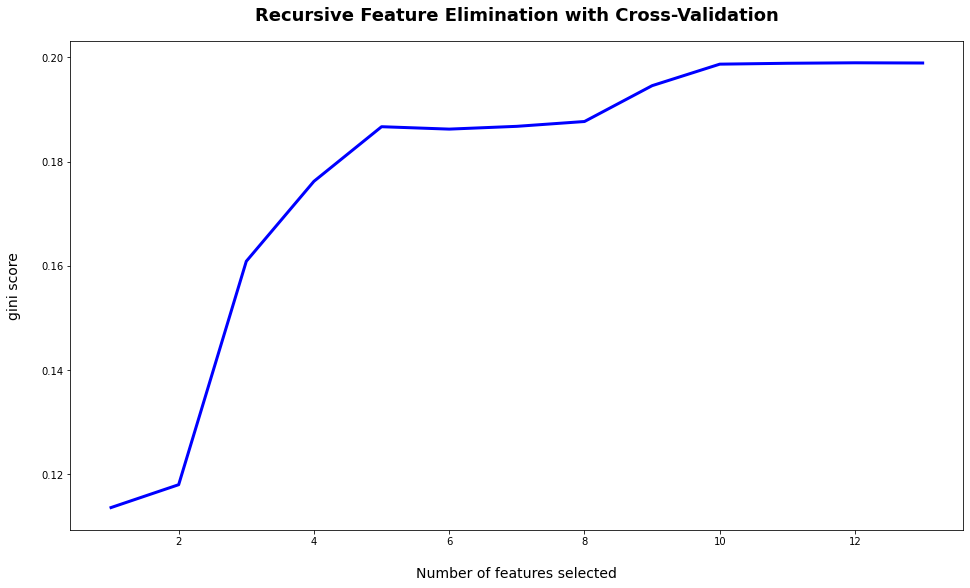

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('gini score', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), (rfecv.grid_scores_)*2-1, color='blue', linewidth=3)

plt.show()

In [35]:
selectednorm=pd.Series(['ps_ind_01', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02',
       'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15','missingmark'])
selectednorm

0       ps_ind_01
1       ps_ind_14
2       ps_ind_15
3       ps_reg_01
4       ps_reg_02
5       ps_reg_03
6       ps_car_11
7       ps_car_12
8       ps_car_13
9       ps_car_14
10      ps_car_15
11    missingmark
dtype: object

In [36]:
prnor_=prnor.loc[:,selectednorm]
prnor_

,ps_ind_01,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,missingmark
0,1.0,0.0,6.0,0.9,0.8,0.611351,3.0,0.447214,0.858646,0.429535,2.645751,2.0
1,3.0,0.0,11.0,0.7,0.6,0.985203,3.0,0.374166,0.839114,0.324808,3.000000,0.0
2,5.0,0.0,13.0,0.7,0.0,0.633936,2.0,0.315595,0.558240,0.368782,2.000000,2.0
3,0.0,0.0,13.0,0.9,0.2,0.590551,3.0,0.374166,0.778455,0.393700,3.162278,1.0
4,1.0,0.0,3.0,0.4,0.0,0.881760,2.0,0.316228,0.609955,0.376829,2.645751,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
374978,2.0,0.0,13.0,0.1,0.1,0.633936,2.0,0.316228,0.578899,0.303315,2.449490,1.0
374979,0.0,0.0,8.0,0.9,0.5,0.675463,3.0,0.400000,0.800839,0.361525,3.605551,1.0
374980,0.0,0.0,3.0,0.9,0.6,0.950000,3.0,0.424264,1.104695,0.353553,3.605551,0.0
374981,5.0,0.0,8.0,0.6,0.0,0.882468,3.0,0.374166,0.816521,0.361525,3.605551,3.0


In [37]:
features_train=pd.concat([prbin,prcat,prnor_],join='outer',axis=1)
selectedfeatures=pd.concat([selected,pd.Series(selectcat),selectednorm],axis=0,ignore_index=True)

In [38]:
features_train.head()

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_11_cat,ps_ind_02_cat_freq,ps_ind_04_cat_freq,ps_ind_05_cat_freq,ps_car_01_cat_freq,ps_car_02_cat_freq,ps_car_04_cat_freq,ps_car_05_cat_freq,ps_car_06_cat_freq,ps_car_07_cat_freq,ps_car_08_cat_freq,ps_car_09_cat_freq,ps_car_11_cat_freq,ps_ind_01,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,missingmark
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3,1,0,11,0,8,1,13,1,1,0,20,0.039831,0.0,1.0,1.000000,0.0,0.041194,1.0,0.037284,1.0,1.0,0.545670,0.008492,1.0,0.0,6.0,0.9,0.8,0.611351,3.0,0.447214,0.858646,0.429535,2.645751,2.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,9,1,0,0,10,1,1,1,28,1.000000,1.0,1.0,0.090468,1.0,1.000000,0.0,0.246041,1.0,1.0,0.073799,0.137092,3.0,0.0,11.0,0.7,0.6,0.985203,3.0,0.374166,0.839114,0.324808,3.000000,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,1,0,10,1,0,1,11,1,1,0,99,1.000000,0.0,1.0,0.236235,1.0,1.000000,1.0,1.000000,1.0,1.0,0.545670,0.130647,5.0,0.0,13.0,0.7,0.0,0.633936,2.0,0.315595,0.558240,0.368782,2.000000,2.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,6,1,0,1,1,1,1,0,70,1.000000,1.0,1.0,0.293594,1.0,1.000000,1.0,0.903339,1.0,1.0,0.545670,0.076887,0.0,0.0,13.0,0.9,0.2,0.590551,3.0,0.374166,0.778455,0.393700,3.162278,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,11,1,0,1,1,1,1,2,10,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,0.903339,1.0,1.0,1.000000,0.089947,1.0,0.0,3.0,0.4,0.0,0.881760,2.0,0.316228,0.609955,0.376829,2.645751,2.0


In [39]:
features_train.describe()

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_11_cat,ps_ind_02_cat_freq,ps_ind_04_cat_freq,ps_ind_05_cat_freq,ps_car_01_cat_freq,ps_car_02_cat_freq,ps_car_04_cat_freq,ps_car_05_cat_freq,ps_car_06_cat_freq,ps_car_07_cat_freq,ps_car_08_cat_freq,ps_car_09_cat_freq,ps_car_11_cat_freq,ps_ind_01,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,missingmark
count,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000,374983.000000
mean,0.393773,0.256870,0.164197,0.185160,0.661801,0.120571,0.152594,1.359872,0.417424,0.413987,8.304568,0.830147,0.726388,0.738975,6.542622,0.949075,0.832619,1.331919,62.187139,0.783073,0.582576,0.899708,0.671467,0.830147,0.842159,0.738975,0.646743,0.949075,0.832619,0.778073,0.214359,1.902665,0.012345,7.304630,0.610674,0.439445,0.847121,2.345544,0.379967,0.813210,0.373793,3.065846,1.423283
std,0.488586,0.436908,0.370455,0.388428,0.473097,0.325628,0.359596,0.664134,0.493135,1.343351,2.506921,0.375504,2.155059,0.439194,5.499991,0.219845,0.373316,0.976523,33.000123,0.357301,0.493135,0.296236,0.367611,0.375504,0.354000,0.439194,0.352499,0.219845,0.373316,0.295814,0.327116,1.984847,0.126577,3.547486,0.287745,0.404648,0.328115,0.833589,0.058280,0.224789,0.044075,0.731155,0.940381
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.075000,0.000000,0.100000,0.287336,0.109545,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,32.000000,0.265621,0.000000,1.000000,0.293594,1.000000,1.000000,0.000000,0.246041,1.000000,1.000000,0.545670,0.042159,0.000000,0.000000,5.000000,0.400000,0.200000,0.633936,2.000000,0.316228,0.670682,0.354260,2.828427,1.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,7.000000,1.000000,0.000000,1.000000,7.000000,1.000000,1.000000,2.000000,65.000000,1.000000,1.000000,1.000000,0.856992,1.000000,1.000000,1.000000,0.839696,1.000000,1.000000,1.000000,0.074782,1.000000,0.000000,7.000000,0.700000,0.300000,0.720677,3.000000,0.374166,0.765501,0.368782,3.316625,2.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000,11.000000,1.000000,0.000000,1.000000,11.000000,1.000000,1.000000,2.000000,93.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.903339,1.000000,1.000000,1.000000,0.137092,3.000000,0.000000,10.000000,0.900000,0.600000,1.000625,3.000000,0.400000,0.906100,0.396863,3.605551,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,6.000000,11.000000,1.000000,9.000000,1.000000,17.000000,1.000000,1.000000,4.000000,104.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,4.000000,13.000000,0.900000,1.800000,4.037945,3.000000,1.264911,3.720626,0.636396,3.741657,8.000000


In [40]:
selectedfeatures

0          ps_ind_06_bin
1          ps_ind_07_bin
2          ps_ind_08_bin
3          ps_ind_09_bin
4          ps_ind_16_bin
5          ps_ind_17_bin
6          ps_ind_18_bin
7          ps_ind_02_cat
8          ps_ind_04_cat
9          ps_ind_05_cat
10         ps_car_01_cat
11         ps_car_02_cat
12         ps_car_04_cat
13         ps_car_05_cat
14         ps_car_06_cat
15         ps_car_07_cat
16         ps_car_08_cat
17         ps_car_09_cat
18         ps_car_11_cat
19    ps_ind_02_cat_freq
20    ps_ind_04_cat_freq
21    ps_ind_05_cat_freq
22    ps_car_01_cat_freq
23    ps_car_02_cat_freq
24    ps_car_04_cat_freq
25    ps_car_05_cat_freq
26    ps_car_06_cat_freq
27    ps_car_07_cat_freq
28    ps_car_08_cat_freq
29    ps_car_09_cat_freq
30    ps_car_11_cat_freq
31             ps_ind_01
32             ps_ind_14
33             ps_ind_15
34             ps_reg_01
35             ps_reg_02
36             ps_reg_03
37             ps_car_11
38             ps_car_12
39             ps_car_13


In [41]:
features_testbin=features_test.loc[:,selected].copy()
features_testbin

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
41660,0.0,0.0,0.0,1.0,1.0,0.0,0.0
41661,0.0,1.0,0.0,0.0,1.0,0.0,0.0
41662,0.0,0.0,1.0,0.0,0.0,1.0,0.0
41663,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [42]:
features_testnor=features_test.loc[:,selectednorm].copy()
features_testnor

,ps_ind_01,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,missingmark
0,0.0,0.0,9.0,0.7,0.2,0.364005,3.0,0.316228,0.674598,0.388716,3.000000,2.0
1,7.0,0.0,7.0,0.6,0.5,0.817007,2.0,0.447214,1.082105,0.400000,3.316625,1.0
2,5.0,0.0,10.0,0.9,1.7,1.325943,3.0,0.519615,1.154322,0.361525,3.162278,1.0
3,0.0,0.0,10.0,0.2,0.2,0.633936,2.0,0.316228,0.833307,0.375500,3.741657,3.0
4,5.0,0.0,9.0,0.9,0.5,0.824242,3.0,0.400000,0.717621,0.397492,2.645751,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
41660,1.0,0.0,4.0,0.4,0.0,0.644205,0.0,0.374166,0.773035,0.428602,3.162278,2.0
41661,4.0,0.0,10.0,0.9,0.5,0.711952,3.0,0.447214,0.691701,0.444972,1.414214,2.0
41662,5.0,0.0,4.0,0.8,0.3,0.642748,2.0,0.374166,0.865620,0.324808,3.605551,0.0
41663,1.0,0.0,9.0,0.3,0.0,0.708872,1.0,0.316070,0.510833,0.355668,2.000000,2.0


In [43]:
feature_testfreq=calculatefreq(selectedcat,features_test)
feature_testfreq

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,missingmark,ps_ind_02_cat_freq,ps_ind_04_cat_freq,ps_ind_05_cat_freq,ps_car_01_cat_freq,ps_car_02_cat_freq,ps_car_04_cat_freq,ps_car_05_cat_freq,ps_car_06_cat_freq,ps_car_07_cat_freq,ps_car_08_cat_freq,ps_car_09_cat_freq,ps_car_11_cat_freq
0,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.7,0.2,0.364005,7.0,1.0,0.0,1.0,11.0,1.0,1.0,2.0,1.0,19.0,3.0,0.316228,0.674598,0.388716,3.000000,0.5,0.5,0.5,1.0,2.0,8.0,1.0,8.0,4.0,11.0,4.0,2.0,2.0,9.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,1.00000,0.0,1.000000,0.874501,1.0,1.000000,1.0,1.000000,1.0,1.0,1.000000,0.053881
1,7.0,1.0,10.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.6,0.5,0.817007,0.0,0.0,0.0,1.0,15.0,1.0,1.0,0.0,1.0,5.0,2.0,0.447214,1.082105,0.400000,3.316625,0.0,0.1,0.2,2.0,2.0,8.0,7.0,11.0,4.0,8.0,3.0,0.0,4.0,3.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.00000,1.0,1.000000,0.024455,0.0,1.000000,1.0,0.158914,1.0,1.0,0.551918,0.138407
2,5.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.9,1.7,1.325943,11.0,0.0,9.0,1.0,17.0,1.0,1.0,2.0,1.0,104.0,3.0,0.519615,1.154322,0.361525,3.162278,0.1,0.2,0.7,5.0,5.0,6.0,1.0,9.0,0.0,12.0,12.0,3.0,1.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.00000,0.0,1.000000,1.000000,0.0,0.038509,1.0,0.023968,1.0,1.0,1.000000,1.000000
3,0.0,1.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.2,0.2,0.633936,7.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,37.0,2.0,0.316228,0.833307,0.375500,3.741657,0.4,0.2,0.0,2.0,2.0,7.0,0.0,10.0,3.0,11.0,6.0,0.0,2.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.00000,1.0,1.000000,0.874501,1.0,1.000000,1.0,0.835504,1.0,0.0,1.000000,0.045294
4,5.0,1.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.9,0.5,0.824242,7.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,98.0,3.0,0.400000,0.717621,0.397492,2.645751,0.9,0.4,0.0,2.0,3.0,7.0,2.0,8.0,0.0,12.0,3.0,2.0,3.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,1.00000,1.0,1.000000,0.874501,1.0,1.000000,1.0,0.835504,1.0,1.0,0.077446,0.020037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41660,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.4,0.0,0.644205,11.0,1.0,2.0,1.0,11.0,1.0,1.0,2.0,1.0,14.0,0.0,0.374166,0.773035,0.428602,3.162278,0.2,0.4,0.3,3.0,0.0,9.0,1.0,11.0,2.0,9.0,3.0,6.0,3.0,5.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,1.00000,1.0,1.000000,1.000000,1.0,0.046839,1.0,1.000000,1.0,1.0,1.000000,0.022394
41661,4.0,2.0,5.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,0.0,0.0,0.9,0.5,0.711952,11.0,0.0,0.0,1.0,11.0,0.0,1.0,2.0,0.0,30.0,3.0,0.447214,0.691701,0.444972,1.414214,0.7,0.2,0.6,3.0,3.0,7.0,4.0,11.0,4.0,7.0,6.0,1.0,3.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.26263,0.0,0.013345,1.000000,0.0,1.000000,1.0,1.000000,0.0,1.0,1.000000,0.015154
41662,5.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.8,0.3,0.642748,11.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,40.0,2.0,0.374166,0.865620,0.324808,3.605551,0.4,0.1,0.3,1.0,0.0,8.0,1.0,9.0,3.0,7.0,0.0,2.0,1.0,10.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.00000,1.0,1.000000,1.000000,1.0,1.000000,0.0,0.889132,1.0,0.0,0.077446,0.044115
41663,1.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,

In [44]:
features_testcat=feature_testfreq.loc[:,selectcat]
features_testcat

,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_11_cat,ps_ind_02_cat_freq,ps_ind_04_cat_freq,ps_ind_05_cat_freq,ps_car_01_cat_freq,ps_car_02_cat_freq,ps_car_04_cat_freq,ps_car_05_cat_freq,ps_car_06_cat_freq,ps_car_07_cat_freq,ps_car_08_cat_freq,ps_car_09_cat_freq,ps_car_11_cat_freq
0,1.0,1.0,0.0,7.0,1.0,0.0,1.0,11.0,1.0,1.0,2.0,19.0,1.00000,0.0,1.000000,0.874501,1.0,1.000000,1.0,1.000000,1.0,1.0,1.000000,0.053881
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,15.0,1.0,1.0,0.0,5.0,1.00000,1.0,1.000000,0.024455,0.0,1.000000,1.0,0.158914,1.0,1.0,0.551918,0.138407
2,1.0,1.0,0.0,11.0,0.0,9.0,1.0,17.0,1.0,1.0,2.0,104.0,1.00000,0.0,1.000000,1.000000,0.0,0.038509,1.0,0.023968,1.0,1.0,1.000000,1.000000
3,1.0,0.0,0.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,37.0,1.00000,1.0,1.000000,0.874501,1.0,1.000000,1.0,0.835504,1.0,0.0,1.000000,0.045294
4,1.0,0.0,0.0,7.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,98.0,1.00000,1.0,1.000000,0.874501,1.0,1.000000,1.0,0.835504,1.0,1.0,0.077446,0.020037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41660,1.0,0.0,0.0,11.0,1.0,2.0,1.0,11.0,1.0,1.0,2.0,14.0,1.00000,1.0,1.000000,1.000000,1.0,0.046839,1.0,1.000000,1.0,1.0,1.000000,0.022394
41661,2.0,1.0,3.0,11.0,0.0,0.0,1.0,11.0,0.0,1.0,2.0,30.0,0.26263,0.0,0.013345,1.000000,0.0,1.000000,1.0,1.000000,0.0,1.0,1.000000,0.015154
41662,1.0,0.0,0.0,11.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,40.0,1.00000,1.0,1.000000,1.000000,1.0,1.000000,0.0,0.889132,1.0,0.0,0.077446,0.044115
41663,2.0,1.0,0.0,6.0,1.0,0.0,1.0,14.0,1.0,1.0,2.0,104.0,0.26263,0.0,1.000000,0.311681,1.0,1.000000,1.0,0.447849,1.0,1.0,1.000000,1.000000


In [45]:
features_test1=pd.concat([features_testbin,features_testcat,features_testnor],join='outer',axis=1)
features_test1

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_11_cat,ps_ind_02_cat_freq,ps_ind_04_cat_freq,ps_ind_05_cat_freq,ps_car_01_cat_freq,ps_car_02_cat_freq,ps_car_04_cat_freq,ps_car_05_cat_freq,ps_car_06_cat_freq,ps_car_07_cat_freq,ps_car_08_cat_freq,ps_car_09_cat_freq,ps_car_11_cat_freq,ps_ind_01,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,missingmark
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,7.0,1.0,0.0,1.0,11.0,1.0,1.0,2.0,19.0,1.00000,0.0,1.000000,0.874501,1.0,1.000000,1.0,1.000000,1.0,1.0,1.000000,0.053881,0.0,0.0,9.0,0.7,0.2,0.364005,3.0,0.316228,0.674598,0.388716,3.000000,2.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,15.0,1.0,1.0,0.0,5.0,1.00000,1.0,1.000000,0.024455,0.0,1.000000,1.0,0.158914,1.0,1.0,0.551918,0.138407,7.0,0.0,7.0,0.6,0.5,0.817007,2.0,0.447214,1.082105,0.400000,3.316625,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,11.0,0.0,9.0,1.0,17.0,1.0,1.0,2.0,104.0,1.00000,0.0,1.000000,1.000000,0.0,0.038509,1.0,0.023968,1.0,1.0,1.000000,1.000000,5.0,0.0,10.0,0.9,1.7,1.325943,3.0,0.519615,1.154322,0.361525,3.162278,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,37.0,1.00000,1.0,1.000000,0.874501,1.0,1.000000,1.0,0.835504,1.0,0.0,1.000000,0.045294,0.0,0.0,10.0,0.2,0.2,0.633936,2.0,0.316228,0.833307,0.375500,3.741657,3.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,7.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,98.0,1.00000,1.0,1.000000,0.874501,1.0,1.000000,1.0,0.835504,1.0,1.0,0.077446,0.020037,5.0,0.0,9.0,0.9,0.5,0.824242,3.0,0.400000,0.717621,0.397492,2.645751,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41660,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,11.0,1.0,2.0,1.0,11.0,1.0,1.0,2.0,14.0,1.00000,1.0,1.000000,1.000000,1.0,0.046839,1.0,1.000000,1.0,1.0,1.000000,0.022394,1.0,0.0,4.0,0.4,0.0,0.644205,0.0,0.374166,0.773035,0.428602,3.162278,2.0
41661,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,3.0,11.0,0.0,0.0,1.0,11.0,0.0,1.0,2.0,30.0,0.26263,0.0,0.013345,1.000000,0.0,1.000000,1.0,1.000000,0.0,1.0,1.000000,0.015154,4.0,0.0,10.0,0.9,0.5,0.711952,3.0,0.447214,0.691701,0.444972,1.414214,2.0
41662,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,11.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,40.0,1.00000,1.0,1.000000,1.000000,1.0,1.000000,0.0,0.889132,1.0,0.0,0.077446,0.044115,5.0,0.0,4.0,0.8,0.3,0.642748,2.0,0.374166,0.865620,0.324808,3.605551,0.0
41663,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,6.0,1.0,0.0,1.0,14.0,1.0,1.0,2.0,104.0,0.26263,0.0,1.000000,0.311681,1.0,1.000000,1.0,0.447849,1.0,1.0,1.000000,1.000000,1.0,0.0,9.0,0.3,0.0,0.708872,1.0,0.316070,0.510833,0.355668,2.000000,2.0


In [46]:
clf_xgb = xgb.XGBClassifier(learning_rate=0.01, 
                            n_estimators=1200, 
                            max_depth=5,
                            min_child_weight=100,
                            gamma=0.2,
                            subsample=.8,
                            colsample_bytree=0.4,
                            objective= 'binary:logistic',
                            nthread=-1,
                            scale_pos_weight=1,
                            reg_alpha = 1,
                            reg_lambda = 3,
                            seed=42)
clf_xgb.fit(features_train,target_train,eval_metric="auc", verbose=100,)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.2,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=100, missing=None, n_estimators=1200, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=1, reg_lambda=3, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, verbosity=1)

In [49]:
target_hat=pd.DataFrame(clf_xgb.predict_proba(features_test1)).iloc[:,1]
score_test=roc_auc_score(target_test,target_hat)
score_test*2-1

0.2614607281944794

In [50]:
testdata=pd.read_csv('/content/drive/My Drive/porto-seguro/test.csv')

In [51]:
id=testdata['id']

In [52]:
testdata.replace(-1,np.nan)

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,1225226,5,2.0,1,0.0,0.0,0,0,1,0,0,0,0,0,0,11,1,0,0,0.0,0.0,NaN,0.0,0.0,NaN,0,1.0,10,1.0,1,0.0,1,83,2.0,0.424264,0.905824,0.418569,2.828427,0.5,0.5,0.2,1,2,7,5,9,2,6,6,1,3,6,0,1,1,0,0,0
1,487111,2,3.0,3,1.0,0.0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.3,0.508060,3.0,1.0,NaN,0,NaN,1,1.0,1,2.0,1,64,3.0,0.315278,0.435629,0.361248,0.000000,0.0,0.0,0.3,3,1,7,2,8,2,9,3,4,0,7,0,1,0,0,1,0
2,1328243,1,1.0,2,1.0,0.0,0,1,0,0,0,0,0,0,0,3,0,1,0,0.9,0.4,0.840387,11.0,0.0,0.0,0,0.0,10,1.0,1,1.0,0,55,2.0,0.447214,1.266333,0.361386,3.741657,0.6,0.3,0.4,1,1,6,2,9,2,8,4,1,2,8,0,1,1,1,0,0
3,388051,2,2.0,2,0.0,0.0,0,0,0,1,0,0,0,0,0,8,1,0,0,0.8,0.3,0.724137,7.0,1.0,NaN,0,NaN,10,1.0,1,2.0,1,28,3.0,0.374166,0.640700,0.378814,2.000000,0.4,0.5,0.6,3,3,8,5,7,2,6,7,0,2,6,0,1,1,1,1,1
4,1454785,0,2.0,5,1.0,0.0,0,1,0,0,0,0,0,0,0,5,1,0,0,0.5,0.3,1.048809,10.0,0.0,NaN,8,1.0,13,1.0,1,0.0,1,20,3.0,0.447214,0.804507,0.429535,2.449490,0.2,0.0,0.3,4,2,7,2,9,4,9,3,1,4,4,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178559,241164,1,1.0,4,0.0,0.0,0,0,0,1,0,0,0,0,0,7,1,0,0,0.0,0.0,0.464354,11.0,1.0,NaN,0,NaN,11,1.0,1,2.0,1,67,2.0,0.374166,0.735704,0.366606,3.464102,0.2,0.0,0.4,3,3,7,2,11,4,7,6,0,3,12,0,1,1,1,0,0
178560,720555,1,2.0,1,1.0,0.0,0,1,0,0,0,0,0,0,0,10,1,0,0,0.9,1.0,1.080798,11.0,1.0,NaN,0,NaN,10,1.0,1,2.0,1,28,3.0,0.374166,0.965521,0.378814,3.605551,0.6,0.3,0.2,0,0,8,3,8,3,9,3,1,2,7,0,1,1,0,0,0
178561,65816,1,1.0,3,1.0,0.0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.1,0.3,NaN,10.0,0.0,NaN,0,1.0,15,1.0,1,0.0,1,5,2.0,0.424264,0.756979,0.400000,2.000000,0.3,0.3,0.8,2,4,7,4,10,3,17,5,3,3,7,0,0,1,1,1,0
178562,538640,0,1.0,5,0.0,0.0,1,0,0,0,0,0,0,0,0,2,0,0,1,0.9,0.2,0.715017,7.0,1.0,NaN,0,NaN,11,1.0,1,0.0,0,11,2.0,0.316228,0.674506,0.368782,3.316625,0.9,0.0,0.5,4,1,8,1,11,3,6,5,2,5,6,0,0,1,0,1,0


In [53]:
testdata['missingmark']=testdata.isnull().sum(1)

In [54]:
testdata.drop(columns=['ps_car_03_cat'],axis=1,inplace=True)


In [55]:
testdata.drop(columns=['id'],axis=1,inplace=True)

In [56]:
testdata=pd.DataFrame(imp.transform(testdata),columns=cols)
testdata.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,missingmark
0,5.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,0.0,-1.000000,0.0,0.0,0.0,1.0,10.0,1.0,1.0,0.0,1.0,83.0,2.0,0.424264,0.905824,0.418569,2.828427,0.5,0.5,0.2,1.0,2.0,7.0,5.0,9.0,2.0,6.0,6.0,1.0,3.0,6.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,2.0,3.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0,0.9,0.3,0.508060,3.0,1.0,0.0,-1.0,1.0,1.0,1.0,2.0,1.0,64.0,3.0,0.315278,0.435629,0.361248,0.000000,0.0,0.0,0.3,3.0,1.0,7.0,2.0,8.0,2.0,9.0,3.0,4.0,0.0,7.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.9,0.4,0.840387,11.0,0.0,0.0,0.0,10.0,1.0,1.0,1.0,0.0,55.0,2.0,0.447214,1.266333,0.361386,3.741657,0.6,0.3,0.4,1.0,1.0,6.0,2.0,9.0,2.0,8.0,4.0,1.0,2.0,8.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0,0.8,0.3,0.724137,7.0,1.0,0.0,-1.0,10.0,1.0,1.0,2.0,1.0,28.0,3.0,0.374166,0.640700,0.378814,2.000000,0.4,0.5,0.6,3.0,3.0,8.0,5.0,7.0,2.0,6.0,7.0,0.0,2.0,6.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.0,2.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.5,0.3,1.048809,10.0,0.0,8.0,1.0,13.0,1.0,1.0,0.0,1.0,20.0,3.0,0.447214,0.804507,0.429535,2.449490,0.2,0.0,0.3,4.0,2.0,7.0,2.0,9.0,4.0,9.0,3.0,1.0,4.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [57]:
testdata.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,missingmark
0,5.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,0.0,-1.000000,0.0,0.0,0.0,1.0,10.0,1.0,1.0,0.0,1.0,83.0,2.0,0.424264,0.905824,0.418569,2.828427,0.5,0.5,0.2,1.0,2.0,7.0,5.0,9.0,2.0,6.0,6.0,1.0,3.0,6.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,2.0,3.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0,0.9,0.3,0.508060,3.0,1.0,0.0,-1.0,1.0,1.0,1.0,2.0,1.0,64.0,3.0,0.315278,0.435629,0.361248,0.000000,0.0,0.0,0.3,3.0,1.0,7.0,2.0,8.0,2.0,9.0,3.0,4.0,0.0,7.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.9,0.4,0.840387,11.0,0.0,0.0,0.0,10.0,1.0,1.0,1.0,0.0,55.0,2.0,0.447214,1.266333,0.361386,3.741657,0.6,0.3,0.4,1.0,1.0,6.0,2.0,9.0,2.0,8.0,4.0,1.0,2.0,8.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0,0.8,0.3,0.724137,7.0,1.0,0.0,-1.0,10.0,1.0,1.0,2.0,1.0,28.0,3.0,0.374166,0.640700,0.378814,2.000000,0.4,0.5,0.6,3.0,3.0,8.0,5.0,7.0,2.0,6.0,7.0,0.0,2.0,6.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.0,2.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.5,0.3,1.048809,10.0,0.0,8.0,1.0,13.0,1.0,1.0,0.0,1.0,20.0,3.0,0.447214,0.804507,0.429535,2.449490,0.2,0.0,0.3,4.0,2.0,7.0,2.0,9.0,4.0,9.0,3.0,1.0,4.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [58]:
testbin=testdata.loc[:,selected].copy()
testbin

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
178559,0.0,0.0,0.0,1.0,1.0,0.0,0.0
178560,0.0,1.0,0.0,0.0,1.0,0.0,0.0
178561,0.0,0.0,1.0,0.0,1.0,0.0,0.0
178562,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [59]:
testnor=testdata.loc[:,selectednorm].copy()
testnor

,ps_ind_01,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,missingmark
0,5.0,0.0,11.0,0.0,0.0,-1.000000,2.0,0.424264,0.905824,0.418569,2.828427,0.0
1,2.0,0.0,8.0,0.9,0.3,0.508060,3.0,0.315278,0.435629,0.361248,0.000000,0.0
2,1.0,0.0,3.0,0.9,0.4,0.840387,2.0,0.447214,1.266333,0.361386,3.741657,0.0
3,2.0,0.0,8.0,0.8,0.3,0.724137,3.0,0.374166,0.640700,0.378814,2.000000,0.0
4,0.0,0.0,5.0,0.5,0.3,1.048809,3.0,0.447214,0.804507,0.429535,2.449490,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
178559,1.0,0.0,7.0,0.0,0.0,0.464354,2.0,0.374166,0.735704,0.366606,3.464102,0.0
178560,1.0,0.0,10.0,0.9,1.0,1.080798,3.0,0.374166,0.965521,0.378814,3.605551,0.0
178561,1.0,0.0,12.0,0.1,0.3,-1.000000,2.0,0.424264,0.756979,0.400000,2.000000,0.0
178562,0.0,0.0,2.0,0.9,0.2,0.715017,2.0,0.316228,0.674506,0.368782,3.316625,0.0


In [60]:
testcatfreq=calculatefreq(selectedcat,testdata)

In [61]:
testcat=testcatfreq.loc[:,selectcat].copy()
testcat

,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_11_cat,ps_ind_02_cat_freq,ps_ind_04_cat_freq,ps_ind_05_cat_freq,ps_car_01_cat_freq,ps_car_02_cat_freq,ps_car_04_cat_freq,ps_car_05_cat_freq,ps_car_06_cat_freq,ps_car_07_cat_freq,ps_car_08_cat_freq,ps_car_09_cat_freq,ps_car_11_cat_freq
0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,1.0,1.0,0.0,83.0,0.288528,1.000000,1.0,0.027654,0.204881,1.000000,0.133738,0.247278,1.0,1.0,0.548287,0.101471
1,3.0,1.0,0.0,3.0,1.0,0.0,-1.0,1.0,1.0,1.0,2.0,64.0,0.065126,0.713074,1.0,0.032565,1.000000,1.000000,1.000000,0.892428,1.0,1.0,1.000000,0.251819
2,1.0,1.0,0.0,11.0,0.0,0.0,0.0,10.0,1.0,1.0,1.0,55.0,1.000000,0.713074,1.0,1.000000,0.204881,1.000000,0.000000,0.247278,1.0,1.0,0.081865,0.037963
3,2.0,0.0,0.0,7.0,1.0,0.0,-1.0,10.0,1.0,1.0,2.0,28.0,0.288528,1.000000,1.0,0.871630,1.000000,1.000000,1.000000,0.247278,1.0,1.0,1.000000,0.135717
4,2.0,1.0,0.0,10.0,0.0,8.0,1.0,13.0,1.0,1.0,0.0,20.0,0.288528,0.713074,1.0,0.241055,0.204881,0.041104,0.133738,0.038178,1.0,1.0,0.548287,0.008779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178559,1.0,0.0,0.0,11.0,1.0,0.0,-1.0,11.0,1.0,1.0,2.0,67.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,0.070943
178560,2.0,1.0,0.0,11.0,1.0,0.0,-1.0,10.0,1.0,1.0,2.0,28.0,0.288528,0.713074,1.0,1.000000,1.000000,1.000000,1.000000,0.247278,1.0,1.0,1.000000,0.135717
178561,1.0,1.0,0.0,10.0,0.0,0.0,1.0,15.0,1.0,1.0,0.0,5.0,1.000000,0.713074,1.0,0.241055,0.204881,1.000000,0.133738,0.156053,1.0,1.0,0.548287,0.135321
178562,1.0,0.0,0.0,7.0,1.0,0.0,-1.0,11.0,1.0,1.0,0.0,11.0,1.000000,1.000000,1.0,0.871630,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.548287,0.069598


In [62]:
testcat.nunique()

ps_ind_02_cat           5
ps_ind_04_cat           3
ps_ind_05_cat           8
ps_car_01_cat          13
ps_car_02_cat           3
ps_car_04_cat          10
ps_car_05_cat           3
ps_car_06_cat          18
ps_car_07_cat           3
ps_car_08_cat           2
ps_car_09_cat           6
ps_car_11_cat         104
ps_ind_02_cat_freq      5
ps_ind_04_cat_freq      3
ps_ind_05_cat_freq      8
ps_car_01_cat_freq     13
ps_car_02_cat_freq      3
ps_car_04_cat_freq     10
ps_car_05_cat_freq      3
ps_car_06_cat_freq     18
ps_car_07_cat_freq      3
ps_car_08_cat_freq      2
ps_car_09_cat_freq      6
ps_car_11_cat_freq    103
dtype: int64

In [63]:
test1=pd.concat([testbin,testcat,testnor],join='outer',axis=1)
test1

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_11_cat,ps_ind_02_cat_freq,ps_ind_04_cat_freq,ps_ind_05_cat_freq,ps_car_01_cat_freq,ps_car_02_cat_freq,ps_car_04_cat_freq,ps_car_05_cat_freq,ps_car_06_cat_freq,ps_car_07_cat_freq,ps_car_08_cat_freq,ps_car_09_cat_freq,ps_car_11_cat_freq,ps_ind_01,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,missingmark
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,1.0,1.0,0.0,83.0,0.288528,1.000000,1.0,0.027654,0.204881,1.000000,0.133738,0.247278,1.0,1.0,0.548287,0.101471,5.0,0.0,11.0,0.0,0.0,-1.000000,2.0,0.424264,0.905824,0.418569,2.828427,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,0.0,3.0,1.0,0.0,-1.0,1.0,1.0,1.0,2.0,64.0,0.065126,0.713074,1.0,0.032565,1.000000,1.000000,1.000000,0.892428,1.0,1.0,1.000000,0.251819,2.0,0.0,8.0,0.9,0.3,0.508060,3.0,0.315278,0.435629,0.361248,0.000000,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,11.0,0.0,0.0,0.0,10.0,1.0,1.0,1.0,55.0,1.000000,0.713074,1.0,1.000000,0.204881,1.000000,0.000000,0.247278,1.0,1.0,0.081865,0.037963,1.0,0.0,3.0,0.9,0.4,0.840387,2.0,0.447214,1.266333,0.361386,3.741657,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,7.0,1.0,0.0,-1.0,10.0,1.0,1.0,2.0,28.0,0.288528,1.000000,1.0,0.871630,1.000000,1.000000,1.000000,0.247278,1.0,1.0,1.000000,0.135717,2.0,0.0,8.0,0.8,0.3,0.724137,3.0,0.374166,0.640700,0.378814,2.000000,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,10.0,0.0,8.0,1.0,13.0,1.0,1.0,0.0,20.0,0.288528,0.713074,1.0,0.241055,0.204881,0.041104,0.133738,0.038178,1.0,1.0,0.548287,0.008779,0.0,0.0,5.0,0.5,0.3,1.048809,3.0,0.447214,0.804507,0.429535,2.449490,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178559,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,11.0,1.0,0.0,-1.0,11.0,1.0,1.0,2.0,67.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,0.070943,1.0,0.0,7.0,0.0,0.0,0.464354,2.0,0.374166,0.735704,0.366606,3.464102,0.0
178560,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,11.0,1.0,0.0,-1.0,10.0,1.0,1.0,2.0,28.0,0.288528,0.713074,1.0,1.000000,1.000000,1.000000,1.000000,0.247278,1.0,1.0,1.000000,0.135717,1.0,0.0,10.0,0.9,1.0,1.080798,3.0,0.374166,0.965521,0.378814,3.605551,0.0
178561,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,10.0,0.0,0.0,1.0,15.0,1.0,1.0,0.0,5.0,1.000000,0.713074,1.0,0.241055,0.204881,1.000000,0.133738,0.156053,1.0,1.0,0.548287,0.135321,1.0,0.0,12.0,0.1,0.3,-1.000000,2.0,0.424264,0.756979,0.400000,2.000000,0.0
178562,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,7.0,1.0,0.0,-1.0,11.0,1.0,1.0,0.0,11.0,1.000000,1.000000,1.0,0.871630,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.548287,0.069598,0.0,0.0,2.0,0.9,0.2,0.715017,2.0,0.316228,0.674506,0.368782,3.316625,0.0


In [65]:
predictionprob1=pd.DataFrame(clf_xgb.predict_proba(test1))
predictionprob1

,0,1
0,0.971569,0.028431
1,0.975337,0.024663
2,0.911218,0.088782
3,0.976178,0.023822
4,0.960765,0.039235
...,...,...
178559,0.973657,0.026343
178560,0.950880,0.049120
178561,0.979985,0.020015
178562,0.978516,0.021484


In [66]:
predictionfinal=pd.DataFrame(id,columns=['id'])
predictionfinal['target']=predictionprob1.iloc[:,1]
predictionfinal

,id,target
0,1225226,0.028431
1,487111,0.024663
2,1328243,0.088782
3,388051,0.023822
4,1454785,0.039235
...,...,...
178559,241164,0.026343
178560,720555,0.049120
178561,65816,0.020015
178562,538640,0.021484


In [67]:
predictionfinal.to_csv('prediction.csv',index=False)